In [1]:
!nvidia-smi

Mon Jun 13 07:25:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!mv "/content/kaggle.json" "/root/.kaggle"

In [4]:
!kaggle datasets download -d gpiosenka/butterfly-images40-species

 99% 361M/365M [00:04<00:00, 82.0MB/s]
100% 365M/365M [00:04<00:00, 81.1MB/s]


In [5]:
!unzip "/content/butterfly-images40-species.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/JULIA/042.jpg     
  inflating: train/JULIA/043.jpg     
  inflating: train/JULIA/044.jpg     
  inflating: train/JULIA/045.jpg     
  inflating: train/JULIA/046.jpg     
  inflating: train/JULIA/047.jpg     
  inflating: train/JULIA/048.jpg     
  inflating: train/JULIA/049.jpg     
  inflating: train/JULIA/050.jpg     
  inflating: train/JULIA/051.jpg     
  inflating: train/JULIA/052.jpg     
  inflating: train/JULIA/053.jpg     
  inflating: train/JULIA/054.jpg     
  inflating: train/JULIA/055.jpg     
  inflating: train/JULIA/056.jpg     
  inflating: train/JULIA/057.jpg     
  inflating: train/JULIA/058.jpg     
  inflating: train/JULIA/059.jpg     
  inflating: train/JULIA/060.jpg     
  inflating: train/JULIA/061.jpg     
  inflating: train/JULIA/062.jpg     
  inflating: train/JULIA/063.jpg     
  inflating: train/JULIA/064.jpg     
  inflating: train/JULIA/065.jpg     
  inflating: train/JULIA/066.jpg     

In [6]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import tensorflow as tf
import keras
import os
import cv2
import sys
import warnings
from sklearn.utils import shuffle
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPool2D

%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)
warnings.filterwarnings('ignore')

In [7]:
working_directory = r'/content/'
train_dir = os.path.join(working_directory, 'train')
test_dir = os.path.join(working_directory, 'test')
val_dir = os.path.join(working_directory, 'valid')

In [8]:
#generating images
img_height = 224
img_width = 224
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=1)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size);

Found 9285 files belonging to 75 classes.
Found 375 files belonging to 75 classes.
Found 375 files belonging to 75 classes.


In [9]:
# checking existing class names
class_names = train_ds.class_names

In [10]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

inputs = pretrained_model.input

x = tf.keras.layers.Dense(4000, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(2056, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)


outputs = tf.keras.layers.Dense(75, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

258088960/258076736 [==============================] - 3s 0us/step


In [11]:
#compiling anad training the model
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=1,).history

Epoch 1/30
146/146 [==============================] - 148s 799ms/step - loss: 3.2481 - accuracy: 0.2938 - val_loss: 5.0443 - val_accuracy: 0.0400
Epoch 2/30
146/146 [==============================] - 111s 760ms/step - loss: 1.7269 - accuracy: 0.5735 - val_loss: 2.1846 - val_accuracy: 0.3707
Epoch 3/30
146/146 [==============================] - 111s 760ms/step - loss: 1.1368 - accuracy: 0.7031 - val_loss: 3.3825 - val_accuracy: 0.2267
Epoch 4/30
146/146 [==============================] - 111s 760ms/step - loss: 0.8858 - accuracy: 0.7654 - val_loss: 0.9008 - val_accuracy: 0.7360
Epoch 5/30
146/146 [==============================] - 111s 760ms/step - loss: 0.7043 - accuracy: 0.8121 - val_loss: 1.4330 - val_accuracy: 0.6400
Epoch 6/30
146/146 [==============================] - 111s 760ms/step - loss: 0.6188 - accuracy: 0.8295 - val_loss: 2.4522 - val_accuracy: 0.4267
Epoch 7/30
146/146 [==============================] - 111s 760ms/step - loss: 0.5695 - accuracy: 0.8476 - val_loss: 0.8391 -

In [12]:
#checking the max and min value
training_features1= ['accuracy', 'val_accuracy']
training_features2= ['loss', 'val_loss']
for feature in training_features1:   
    print("The best max value obtained for {} is :".format(feature),max(hist[feature]))

for feature in training_features2:   
    print("The best min value obtained for {} is :".format(feature),min(hist[feature]))

The best value obtained for accuracy is : 0.9586429595947266
The best value obtained for val_accuracy is : 0.909333348274231
The best value obtained for loss is : 0.15289565920829773
The best value obtained for val_loss is : 0.3013122081756592


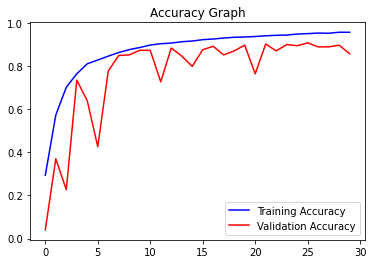

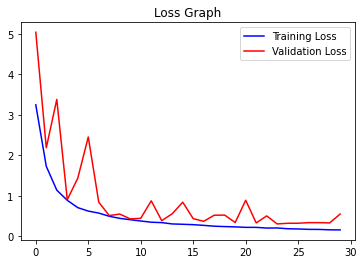

In [13]:
#plotting loss vs val_loss and acc vs val_acc
acc = hist['accuracy']
val_acc = hist['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = hist['loss']
val_loss = hist['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [15]:
#saving model
model.save('butterfly_species_classification.h5')

In [16]:
#saving weights
model.save_weights('weights.h5')

In [17]:
#checking the accuracy
from sklearn.metrics import classification_report
# Get ground truth
y_true = []
for images, labels in test_ds:   
    for label in labels:
        y_true.append(class_names[label])

# predict
y_pred = []
errors = 0
count = 0
preds = model.predict(test_ds)
for i, p in enumerate(preds):
    count += 1
    index = np.argmax(p)
    y_pred.append(class_names[index])  
    if class_names[index] != y_true[i]:
        errors += 1

print("Accuracy",(count-errors)* 100/count)
classification_report(np.array(y_true), np.array(y_pred), target_names=class_names);

Accuracy 8.0


This image most likely belongs to CABBAGE WHITE 


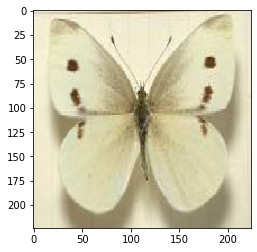

In [23]:
#testing the model
from matplotlib import pyplot as plt
img = tf.keras.preprocessing.image.load_img(r'/content/w.jpg',target_size=(img_height, img_width))
img_array = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(img), 0)

score = tf.nn.softmax(model.predict(img_array))
print("This image most likely belongs to {} ".format(class_names[np.argmax(score)]))
plt.imshow(img)